In [1]:
import datetime

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.seasonal import seasonal_decompose

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wind-energy-germany/germany-wind-energy.csv


# Load data

- Homepage [here](https://www.kaggle.com/aymanlafaz/wind-energy-germany)

The columns in the dataset are :

- utc_timestamp : Time in UTC
- wind_generation : Daily wind production in MW
- wind_capacity : Electrical capacity of wind in MW
- temperature : Daily Temperature in degrees CThe columns in the dataset are :

In [2]:
raw = pd.read_csv('../input/wind-energy-germany/germany-wind-energy.csv')
print(raw.shape)
raw.head()

(1094, 4)


,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908


## Preprocessing

In [3]:
df = (
    raw
    .assign(utc_timestamp = lambda x: x['utc_timestamp'].apply(lambda x: pd.to_datetime(x).tz_localize(None)))
    # This is pointless, the data is at the day level
    # .assign(hour = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).hour))
    .assign(year = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).year))
    .assign(month = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).month))
)

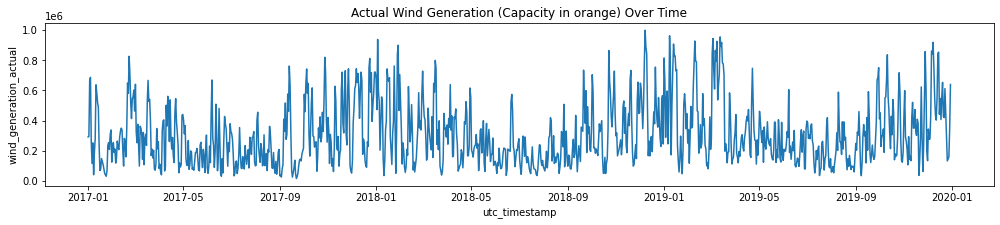

In [4]:
fig, ax = plt.subplots(figsize=(17, 3))

sns.lineplot(x='utc_timestamp', y='wind_generation_actual', data=df, ax=ax);
#sns.lineplot(x='utc_timestamp', y='wind_capacity', data=df);
plt.title('Actual Wind Generation (Capacity in orange) Over Time');

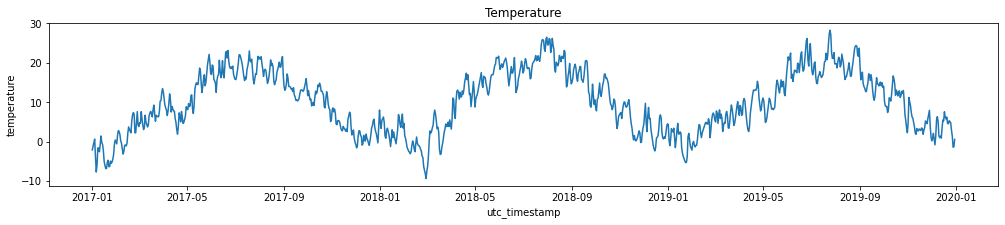

In [5]:
fig, ax = plt.subplots(figsize=(17, 3))

sns.lineplot(x='utc_timestamp', y='temperature', data=df, ax=ax);
plt.title('Temperature');

# Time Series Modeling

- Resource [here](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

### (there is some) Investigate Auto-Correlation

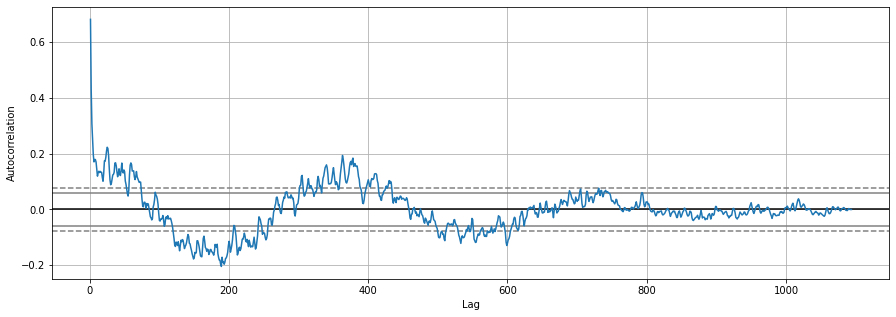

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(df['wind_generation_actual'], ax = ax);

### Decomposition

['nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']


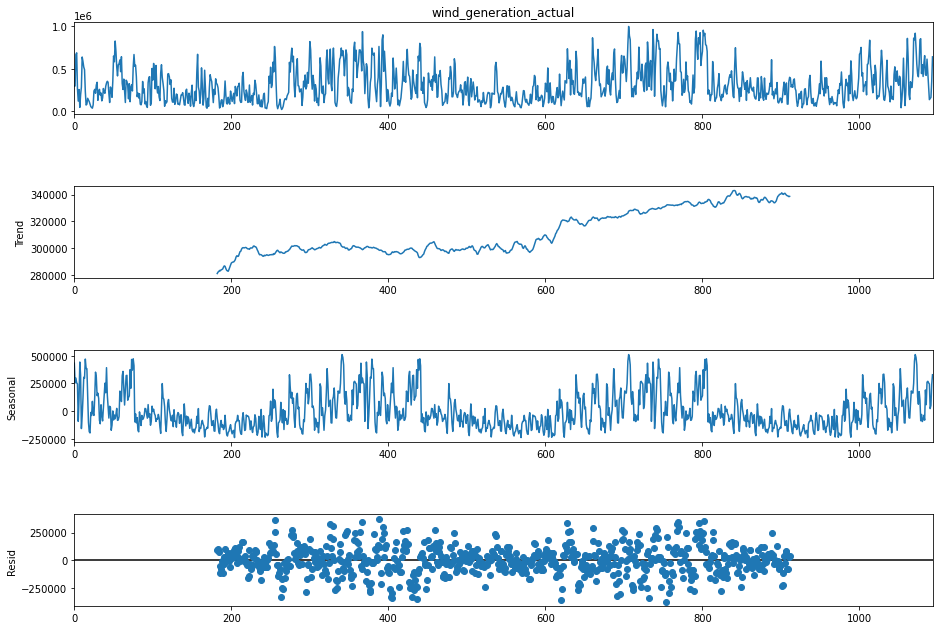

In [7]:
result = seasonal_decompose(
    df['wind_generation_actual'], model='additive', 
    period=365
)

print([x for x in dir(result) if not x.startswith('_')])

result.plot();
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(10)

### (AR) Autoregression

(365,)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


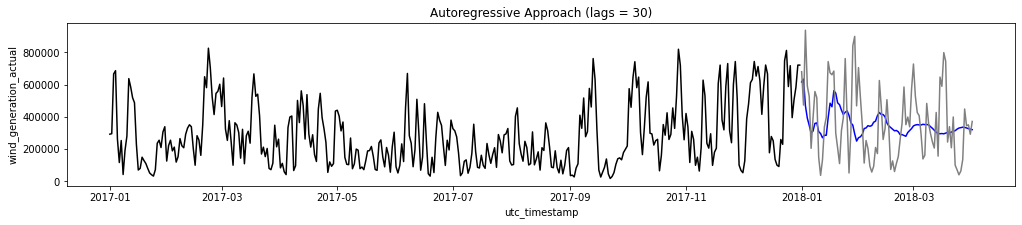

In [8]:
N_LAGS = 30
PRED_START = datetime.datetime(2018, 1, 1)
PRED_END = datetime.datetime(2018, 4, 1)

train_dat = (
    df
    .loc[lambda x: x['utc_timestamp'] < PRED_START]
    .set_index('utc_timestamp')
    ['wind_generation_actual']
)
print(train_dat.shape)

model = AutoReg(
    train_dat, 
    lags=N_LAGS
).fit()

def plot_mod(mod, t_dat, base_dat, p_start, p_end):
    yhats = mod.predict(start=p_start, end=p_end)
    fig, ax = plt.subplots(figsize=(17, 3))

    sns.lineplot(data=yhats, color='blue', ax=ax);
    sns.lineplot(data=t_dat, color='black', ax=ax);
    sns.lineplot(
        data=(
            base_dat
            .loc[lambda x: x['utc_timestamp'] <= PRED_END]
            .loc[lambda x: x['utc_timestamp'] >= PRED_START]
            .set_index('utc_timestamp')
            ['wind_generation_actual']
        ), 
        color='grey',
        ax=ax
    );

    plt.title(f'Autoregressive Approach (lags = {N_LAGS})');


plot_mod(
    model,
    train_dat,
    df,
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 4, 1)
)

### (MA) Moving Average

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


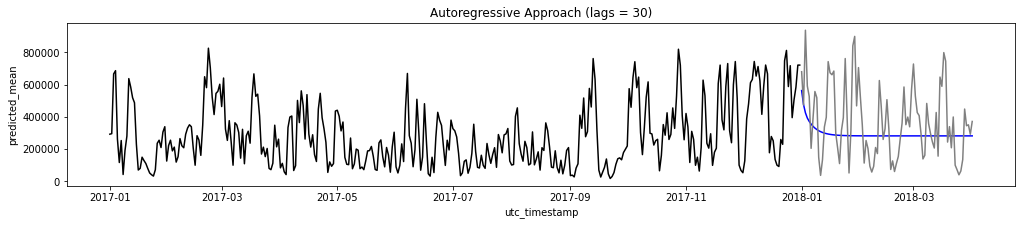

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_dat, order=(1, 0, 5))
new_mod = model.fit()

plot_mod(
    new_mod,
    train_dat,
    df,
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 4, 1)
)

### (ARMA) Autoregressive Moving Average

### (ARIMA) Autoregressive Integrated Moving Average

### SARIMAX 